In [1]:
!pip install geomle

In [1]:
import sys
import os
from os import path
current_folder = path.dirname(path.abspath('')) 
sys.path.append(current_folder)
from estimators import *
from geomle import geomle, mle, DataGenerator
import multiprocessing as mp
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from scipy.linalg import cholesky
from scipy.special import gammainc, lambertw
import scipy.io
import matplotlib as mpl
from matplotlib import pyplot as plt
import umap
import seaborn as sns
import random
import time
import numpy as np
import pandas as pd
import pickle
import rpy2
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
import rpy2.robjects.packages as rpackages
from functools import wraps
import subprocess
from IPython.display import display_html
from operator import itemgetter
ig0 = itemgetter(0)
ig1 = itemgetter(1)
ig2 = itemgetter(2)
rpy2.robjects.numpy2ri.activate()
utils = rpackages.importr('utils')
#utils.install_packages('intrinsicDimension')
#utils.install_packages('ider')
intdimr = rpackages.importr('intrinsicDimension')
ider   = rpackages.importr('ider')
r_base = rpackages.importr('base')

In [2]:
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

def mean_sqe(estimations, truth):
    '''
    Mean squared error 
    '''
    return ((estimations - truth)^2/truth).sum() /len(truth) 
    
def mean_pe(estimations, truth):
    '''
    Mean percentage error 
    '''
    return (abs(estimations - truth)/truth).sum() /len(truth)*100

def mean_ge(estimations, truth):
    '''
    Mean geometric error: The geometric mean of the error *ratio*. It is always >= 1.
    '''
    ratios = np.concatenate(((estimations/truth)[np.newaxis, :], (truth/estimations)[np.newaxis, :]), axis=0)
    return np.power(ratios.max(axis=0).prod(), 1.0/len(estimations))

def med_pe(estimations, truth):
    '''
    Median error in %.
    '''
    return np.percentile(abs(estimations - truth)/truth, q=50)*100


def randball(n_points,ndim,radius,center = []):
    ''' Generate uniformly sampled ndim-sphere interior'''
    if center == []:
        center = np.array([0]*ndim)
    r = radius
    x = np.random.normal(size=(n_points, ndim))
    ssq = np.sum(x**2,axis=1)
    fr = r*gammainc(ndim/2,ssq/2)**(1/ndim)/np.sqrt(ssq)
    frtiled = np.tile(fr.reshape(n_points,1),(1,ndim))
    p = center + np.multiply(x,frtiled)
    return p, center

def proxy(tup):
    function,X,Dict = tup
    return function(X,**Dict)

def get_nn(X,k,n_jobs=1):
    neigh = NearestNeighbors(n_neighbors=k,n_jobs=n_jobs)
    neigh.fit(X)
    dists, inds = neigh.kneighbors(return_distance=True)
    return dists,inds

def asPointwise(data,function, params, precomputed_knn = None, n_neighbors=100, n_jobs=1):
    '''Use a global estimator as a pointwise one by creating kNN neighborhoods'''
    if precomputed_knn is not None:
        knn = precomputed_knn
    else:
        _, knn = get_nn(data, k=n_neighbors, n_jobs=n_jobs)
        
    if n_jobs > 1:
        pool = mp.Pool(n_jobs)
        results = pool.map(proxy,[(function,data[i,:],params) for i in knn])
        pool.close()
        return results
    else:
        return [function(data[i,:],**params) for i in knn]

def point_inseparability_to_pointID(n_alpha,n_single,p_alpha,alphas,idx='all_separable'):
    '''
    idx : int, string
        Int for custom alpha index
        'all_separable' to choose alpha where lal points have non-zero inseparability probability
        'selected' to keep global alpha selected
    
    '''
    if idx == 'all_separable': #all points are separable
        selected_idx = np.argwhere(np.all(p_alpha!=0,axis=1)).max()
    elif idx == 'selected': #
        selected_idx = (n_alpha==n_single).tolist().index(True)   
    elif idx == int:
        selected_idx = idx
    else:
        raise ValueError('unknown idx parameter')
        
    palpha_selected = p_alpha[selected_idx,:]
    alpha_selected = alphas[0,selected_idx]
    
    
    py=palpha_selected
    alphas=np.repeat(alpha_selected,len(palpha_selected))[None]
    
    if len(py)!=len(alphas[0,:]):
        raise ValueError('length of py (%i) and alpha (%i) does not match'%(len(py),len(alphas[0,:])))

    if np.sum(alphas <= 0) > 0 or np.sum(alphas >= 1) > 0:
        raise ValueError(['"Alphas" must be a real vector, with alpha range, the values must be within (0,1) interval'])

    #Calculate dimension for each alpha
    n = np.zeros((len(alphas[0,:])))
    for i in range(len(alphas[0,:])):
        if py[i] == 0:
            #All points are separable. Nothing to do and not interesting
            n[i]=np.nan
        else:
            p  = py[i]
            a2 = alphas[0,i]**2
            w = np.log(1-a2)
            n[i] = lambertw(-(w/(2*np.pi*p*p*a2*(1-a2))))/(-w)

    n[n==np.inf] = float('nan')
    #Find indices of alphas which are not completely separable 
    inds = np.where(~np.isnan(n))[0]
    print(str(len(inds))+'/'+str(len(py)),'points have nonzero inseparability probability for chosen alpha =',alpha_selected)
    return n, inds

from functools import wraps
def calculate_time(func): 
    @wraps(func)
    def inner_func(*args, **kwargs): 
        begin = time.time() 
        res = func(*args, **kwargs) 
        end = time.time()
        return res, end - begin
    return inner_func

class DimEst():
    def __init__(self):
        self.names = ['MLE', 'GeoMLE', 'MIND', 'DANCo', 'FastDANCo', 'ESS', 'PCA', 'CD','FisherS','ANOVA','TwoNN']
        self.caldatas = {}
        
    def estimateAllMethods(self, data):
        dim = data.shape[1]
        self.funcs = {'MLE':          self.mle(data),
                      #'GeoMLE':       self.geomle(data, dim),
                      'MiND':         self.mind_mlk(data, dim),
                      #'DANCo':        self.danco(data, dim),
                      'FastDANCo':    self.fast_danco(data),
                      'ESS':          self.ess(data),
                      #'PCA':          self.pca(data),
                      #'CD':           self.cd(data),
                      'FisherS':      self.fisherS(data),
                      'ANOVA':        self.anova(data),
                      'TwoNN':        self.twonn(data)
                     }
                      
        self.times = {key: ig1(val) for key, val in self.funcs.items()}
        self.funcs = {key: ig0(val) for key, val in self.funcs.items()}
        return self.funcs, self.times
    
    def estimateAllMethodsLocally(self, data, k, n_jobs = 1):
        dim = data.shape[1]
        
        _, knn = get_nn(data, k, n_jobs)
        
        self.funcs = {'MLE':          self.mlelocal(data,k),
                      #'GeoMLE':       self.geomle(data, dim),
                      'MiND':         asPointwise(data,self.mind_mlk,{'dim':dim},precomputed_knn=knn,n_jobs=1),
                      #'DANCo':        asPointwise(data,self.danco,{'dim':dim},precomputed_knn=knn,n_jobs=1),
                      'FastDANCo':    self.fast_dancoloop(data),
                      'ESS':          asPointwise(data,self.ess,{},precomputed_knn=knn,n_jobs=1),
                      #'PCA':          self.pca(data),
                      #'CD':           self.cd(data),
                      'FisherS':      asPointwise(data,self.fisherS,{},precomputed_knn=knn,n_jobs=n_jobs),
                      'ANOVA':        self.anovalocal(data,k),
                      'TwoNN':        asPointwise(data,self.twonn,{},precomputed_knn=knn,n_jobs=n_jobs)
                     }
                      
        self.times = {}
        for key, val in self.funcs.items():
            if key in ['MLE','ANOVA','FastDANCo']:
                self.funcs[key] = np.array(val[0])
                self.times[key] = val[1]
            else:
                self.funcs[key] = np.array([i[0] for i in val])
                self.times[key] = np.sum([i[1] for i in val])
            
        return self.funcs, self.times
    
    @staticmethod
    @calculate_time
    def mle(data):
        return intdimr.maxLikGlobalDimEst(data,k=20).rx2('dim.est')[0]
    
    @staticmethod
    @calculate_time
    def mlelocal(data,k):
        res = intdimr.maxLikPointwiseDimEst(data,k=k)
        return np.array([i[0] for i in res])

    @staticmethod
    @calculate_time
    def geomle(data, dim):
#         k1 =  k1_log(dim)
#         k2 =  k2_log(dim)
        return geomle(pd.DataFrame(data), k1=20, k2=55, nb_iter1=1, alpha=5e-3).mean()
    
    @staticmethod
    @calculate_time
    def mind_mlk(data, dim):
        return intdimr.dancoDimEst(data, k=10, D=min(dim,100), ver="MIND_MLk").rx2('dim.est')[0]
    
    #@staticmethod
    @calculate_time
    def danco(self,data, dim):
        try:
            res = intdimr.dancoDimEst(data, k=10, D=min(dim,100), calibration_data = self.caldatas[len(data)], ver="DANCo")
            self.caldatas[len(data)]=res[2]
            return res.rx2('dim.est')[0]
        except:
            res = intdimr.dancoDimEst(data, k=10, D=min(dim,100), ver="DANCo")
            self.caldatas[len(data)]=res[2]
            return res.rx2('dim.est')[0]

    @staticmethod
    @calculate_time
    def fast_danco(data):
        return runDANCo(data)[0]
    
    @staticmethod
    @calculate_time
    def fast_dancoloop(data):
        return runDANColoop(data)[0]
    
    @staticmethod
    @calculate_time
    def ess(data):
        return ess_py(data)[0]
    
    @staticmethod
    @calculate_time
    def pca(data):
        return intdimr.pcaLocalDimEst(data, 'FO').rx2('dim.est')[0]
    
    @staticmethod
    @calculate_time
    def cd(data):
        return corint_py(data, k1=10, k2=20)[0]
    
    @staticmethod
    @calculate_time
    def fisherS(data):
        return SeparabilityAnalysis(data,ProducePlots=0,alphas=np.arange(.2,1,.02)[None])[1][0]
    
    @staticmethod
    @calculate_time
    def anova(data):
        return runANOVAglobal(data)[0,0]
    
    @staticmethod
    @calculate_time
    def anovalocal(data,k):
        return runANOVAlocal(data,k=k)[:,0]
    
    @staticmethod
    @calculate_time
    def twonn(data):
        res = twonn_py(data)
        return res    

In [90]:
def point_inseparability_to_pointID_old_all_alphas(p_alpha,alphas=np.arange(.6,1,.02)[None], eps = 1e-100):
    '''returns point ID from point inseparability values, fitting all alphas:
    * instead of feeding mean point p_alphas and given alphas, we feed point p_alphas and given alphas to dimension_uniform_ball
    * dimension_uniform_ball_robust is used instead of the base function to handle all 0 case and returns chosen alphas index 
    '''
    
    #correct for 0 to avoid NaNs
    palphas_zero_corrected = p_alpha.T.copy()

    n_singles = np.zeros(len(palphas_zero_corrected))
    alpha_singles = np.zeros(len(palphas_zero_corrected))
    alpha_idx = np.zeros(len(palphas_zero_corrected))

    #for each point, check inseparability prob vector (one alpha-> one value)
    for i,palpha in enumerate(palphas_zero_corrected):
        n_alpha,n_singles[i],alpha_singles[i],alpha_idx[i] = dimension_uniform_ball_robust(palpha,alphas)
    return n_singles, alpha_singles, alpha_idx


def point_inseparability_to_pointID(n_alpha,n_single,p_alpha,alphas,idx='all_separable'):
    '''
    idx : int, string
        Int for custom alpha index
        'all_separable' to choose alpha where lal points have non-zero inseparability probability
        'selected' to keep global alpha selected
    
    '''
    if idx == 'all_separable': #all points are separable
        selected_idx = np.argwhere(np.all(p_alpha!=0,axis=1)).max()
    elif idx == 'selected': #
        selected_idx = (n_alpha==n_single).tolist().index(True)   
    elif idx == int:
        selected_idx = idx
    else:
        raise ValueError('unknown idx parameter')
        
    palpha_selected = p_alpha[selected_idx,:]
    alpha_selected = alphas[0,selected_idx]
    
    
    py=palpha_selected
    alphas=np.repeat(alpha_selected,len(palpha_selected))[None]
    
    if len(py)!=len(alphas[0,:]):
        raise ValueError('length of py (%i) and alpha (%i) does not match'%(len(py),len(alphas[0,:])))

    if np.sum(alphas <= 0) > 0 or np.sum(alphas >= 1) > 0:
        raise ValueError(['"Alphas" must be a real vector, with alpha range, the values must be within (0,1) interval'])

    #Calculate dimension for each alpha
    n = np.zeros((len(alphas[0,:])))
    for i in range(len(alphas[0,:])):
        if py[i] == 0:
            #All points are separable. Nothing to do and not interesting
            n[i]=np.nan
        else:
            p  = py[i]
            a2 = alphas[0,i]**2
            w = np.log(1-a2)
            n[i] = lambertw(-(w/(2*np.pi*p*p*a2*(1-a2))))/(-w)

    n[n==np.inf] = float('nan')
    #Find indices of alphas which are not completely separable 
    inds = np.where(~np.isnan(n))[0]
    print(str(len(inds))+'/'+str(len(py)),'points have nonzero inseparability probability for chosen alpha =',alpha_selected)
    return n, inds

# Real data

In [5]:
DE=DimEst()

### Load Nestorowa

In [28]:
%load_ext rpy2.ipython

In [29]:
%%R 
library(readr)
Header <- read_delim(file = "../data/nestorowa_corrected_log2_transformed_counts.txt.gz", col_names = FALSE, delim = " ", n_max = 1)
ExpMat <- read_delim(file = "../data/nestorowa_corrected_log2_transformed_counts.txt.gz", col_names = FALSE, delim = " ", skip = 1)
Genes <- unlist(Header)
Cells <- unlist(ExpMat$X1)
ExpMat <- data.matrix(ExpMat[,-1])
colnames(ExpMat) <- Genes
rownames(ExpMat) <- Cells
ExtraInfo_Head <- read_delim("../data/all_cell_types.txt", col_names = FALSE, delim = "\t", n_max = 1)
ExtraInfo <- read_delim("../data/all_cell_types.txt", col_names = FALSE, delim = "\t", skip = 1)
ExtraInfo_Bin <- data.matrix(ExtraInfo[,-1])
rownames(ExtraInfo_Bin) <- unlist(ExtraInfo$X1)
colnames(ExtraInfo_Bin) <- unlist(ExtraInfo_Head)
PopID_broad <- apply(ExtraInfo_Bin[,grep("broad", colnames(ExtraInfo_Bin))], 1, function(x){
  if(sum(x==1)>1 | sum(x==1)==0){
    return(NA)
  } else {
    return(which(x==1))
  }
})
PopID_broad <- colnames(ExtraInfo_Bin)[PopID_broad]
names(PopID_broad) <- unlist(ExtraInfo$X1)
names(PopID_broad) <- gsub(pattern = "-", replacement = ".", x = names(PopID_broad))
PopID_broad_Fil <- PopID_broad[rownames(ExpMat)]
table(PopID_broad_Fil, useNA = "if")

R[write to console]: Parsed with column specification:
cols(
  .default = col_character()
)

R[write to console]: See spec(...) for full column specifications.

R[write to console]: Parsed with column specification:
cols(
  .default = col_double(),
  X1 = col_character()
)

R[write to console]: See spec(...) for full column specifications.

R[write to console]: Parsed with column specification:
cols(
  .default = col_character()
)

R[write to console]: See spec(...) for full column specifications.

R[write to console]: Parsed with column specification:
cols(
  .default = col_double(),
  X1 = col_character()
)

R[write to console]: See spec(...) for full column specifications.



PopID_broad_Fil
  CMP_broad   GMP_broad  LMPP_broad LTHSC_broad   MEP_broad        <NA> 
        317         120         246         267         354         341 


In [30]:
nestorowa = %Rget ExpMat

PopID = %Rget PopID_broad_Fil
PopID = list(PopID)
switch = {'CMP_broad':0,'GMP_broad':1,'LMPP_broad':2,'LTHSC_broad':3,'MEP_broad':4, 'NA':-1}
popCol = []
inds = [i for i in range(len(PopID))]
for i0,i in enumerate(PopID):
    if i in switch:
        popCol.append(switch[i])
    else:
        inds.remove(i0)

In [31]:
pca_nestorowa = preprocessing(nestorowa,center=1,dimred=1,whiten=0,projectonsphere=0,ConditionalNumber=100)

167 components are retained using factor 100.00


In [12]:
pca=PCA()
projection = pca.fit_transform(nestorowa)
#retain top components
s = pca.explained_variance_
sc = s/s[0]
ind = np.where(sc > 1/ConditionalNumber)[0]
proj_data = projection[:,ind]

In [23]:
percexp=s/s.sum()

In [8]:
plt.plot(percexp);plt.show()
plt.plot(np.cumsum(percexp))

NameError: name 'percexp' is not defined

In [23]:
import scanpy.api as sc
adata = sc.read('../data/nestorowa_corrected_log2_transformed_counts.txt', cache=True)
cell_types = pd.read_csv('../data/nestorowa_corrected_population_annotation.txt', delimiter=' ')
# Replace the long names with the acronyms and make this a vector of the length of the number of observations.
acronyms = {'ESLAM': 'Stem', 'Erythroid': 'Ery', 'Megakaryocytes': 'Mk', 'Basophils': 'Baso',
            'Neutrophils': 'Neu', 'Monocytes': 'Mo', 'Bcell': 'B'}
cell_types = [acronyms[cell_types.loc[cell_id, 'celltype']]
              if cell_id in cell_types.index else 'no_gate' for cell_id in adata.obs_names]

In [36]:
numerical_labels=dict(zip(np.arange(8),np.unique(cell_types)))
numerical_labels[-1] = numerical_labels.pop(7)

In [53]:
from sklearn.preprocessing import LabelEncoder
numerical_labels=LabelEncoder().fit_transform(cell_types)
numerical_labels[numerical_labels==7]=-1

In [61]:
np.unique(numerical_labels)

array([-1,  0,  1,  2,  3,  4,  5,  6])

In [58]:
np.unique(cell_types)

array(['B', 'Baso', 'Ery', 'Mk', 'Mo', 'Neu', 'Stem', 'no_gate'],
      dtype='<U7')

In [62]:
np.random.seed(0);umap_emb = umap.UMAP(n_neighbors=20).fit_transform(nestorowa,y=numerical_labels)

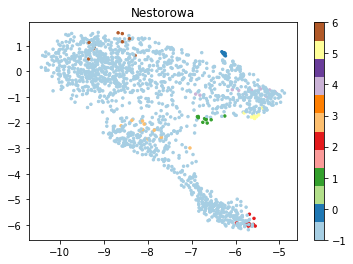

In [69]:
plt.scatter(umap_emb[:,0],umap_emb[:,1],c=numerical_labels,cmap=plt.cm.Paired,s=6);plt.title('Nestorowa');plt.colorbar();plt.show()

### Global ID saturation analysis

In [11]:
# testing separability saturation

n_repeats = 10
sample_sizes = [10,15,20,25,30,50,70,90]
sample_sizes_halves = [x/2 for x in sample_sizes]

all_sample_sizes = sample_sizes+sample_sizes_halves
all_sample_sizes = list(set(all_sample_sizes))
all_sample_sizes.sort()

#for key,data in real_data_subsampled.items():
for key,data in [('nestorowa',pca_nestorowa)]:

    dataset_name = key
    n_samples = data.shape[0]

    print(dataset_name)
    print('Running subsampling analysis...\nSubsample percentages = {}\nNumber of repeats = {}\nNumber of samples = {}\nDimension = {}'.format(sample_sizes,n_repeats,n_samples,data.shape[1]))
    print('----------------------------\n')

    fisherS_dim_estimates = np.empty([len(all_sample_sizes)+1,n_repeats])
    ess_dim_estimates = np.empty([len(all_sample_sizes)+1,n_repeats])
    danco_dim_estimates = np.empty([len(all_sample_sizes)+1,n_repeats])
    twonn_dim_estimates = np.empty([len(all_sample_sizes)+1,n_repeats])
    anova_dim_estimates = np.empty([len(all_sample_sizes)+1,n_repeats])
    mle_dim_estimates = np.empty([len(all_sample_sizes)+1,n_repeats])
    mind_dim_estimates = np.empty([len(all_sample_sizes)+1,n_repeats])

    runtimes = []
    for i,sz in enumerate(all_sample_sizes):
        sample_size = int(n_samples*sz/100)
        print('Sample size = {}'.format(sample_size))
        start_time = time.time()
        for j in range(0,n_repeats):
            sample = np.random.choice(n_samples,replace=False, size=sample_size)
            xs = data[sample,:]

            #Run estimators
            allres = DE.estimateAllMethods(xs)
            results = allres[0]
            runtimes.append(allres[1])

            #Store
            fisherS_dim_estimates[i,j] = results['FisherS']
            ess_dim_estimates[i,j] = results['ESS']
            danco_dim_estimates[i,j] = results['FastDANCo']
            twonn_dim_estimates[i,j] = results['TwoNN']
            anova_dim_estimates[i,j] = results['ANOVA']
            mle_dim_estimates[i,j] = results['MLE']
            mind_dim_estimates[i,j] = results['MiND']


        print("Elapsed time = {}".format(time.time()-start_time))

    allres = DE.estimateAllMethods(data)
    results = allres[0]
    runtimes.append(allres[1])

    for i in range(0,n_repeats):
        fisherS_dim_estimates[len(all_sample_sizes),i] = results['FisherS']
        ess_dim_estimates[len(all_sample_sizes),i] = results['ESS']
        danco_dim_estimates[len(all_sample_sizes),i] = results['FastDANCo']
        twonn_dim_estimates[len(all_sample_sizes),i] = results['TwoNN']
        anova_dim_estimates[len(all_sample_sizes),i] = results['ANOVA']
        mle_dim_estimates[len(all_sample_sizes),i] = results['MLE']
        mind_dim_estimates[len(all_sample_sizes),i] = results['MiND']


    all_sample_sizes.append(100)
    sample_sizes.append(100)

    np.savetxt("../results/"+dataset_name+"_fisherS_dim_estimates.txt", fisherS_dim_estimates, delimiter="\t")
    np.savetxt("../results/"+dataset_name+"_ess_dim_estimates.txt", ess_dim_estimates, delimiter="\t")
    np.savetxt("../results/"+dataset_name+"_danco_dim_estimates.txt", danco_dim_estimates, delimiter="\t")
    np.savetxt("../results/"+dataset_name+"_twonn_dim_estimates.txt", twonn_dim_estimates, delimiter="\t")
    np.savetxt("../results/"+dataset_name+"_anova_dim_estimates.txt", anova_dim_estimates, delimiter="\t")
    np.savetxt("../results/"+dataset_name+"_mle_dim_estimates.txt", mle_dim_estimates, delimiter="\t")
    np.savetxt("../results/"+dataset_name+"_mind_dim_estimates.txt", mind_dim_estimates, delimiter="\t")

    np.savetxt("../results/"+dataset_name+"_all_sample_sizes.txt", all_sample_sizes, delimiter="\t")
    np.savetxt("../results/"+dataset_name+"_sample_sizes.txt", sample_sizes, delimiter="\t")

nestorowa
Running subsampling analysis...
Subsample percentages = [10, 15, 20, 25, 30, 50, 70, 90]
Number of repeats = 10
Number of samples = 1645
Dimension = 167
----------------------------

Sample size = 82
Elapsed time = 71.61480402946472
Sample size = 123
Elapsed time = 73.76762652397156
Sample size = 164
Elapsed time = 76.33560919761658
Sample size = 205
Elapsed time = 77.52109408378601
Sample size = 246
Elapsed time = 80.19205093383789
Sample size = 329
Elapsed time = 82.54617643356323
Sample size = 411
Elapsed time = 86.9110164642334
Sample size = 493
Elapsed time = 92.10079050064087
Sample size = 575
Elapsed time = 98.04548764228821
Sample size = 740
Elapsed time = 113.2398099899292
Sample size = 822
Elapsed time = 134.47821688652039
Sample size = 1151
Elapsed time = 173.1402235031128
Sample size = 1480
Elapsed time = 228.95402932167053


fisherS_dim_estimates


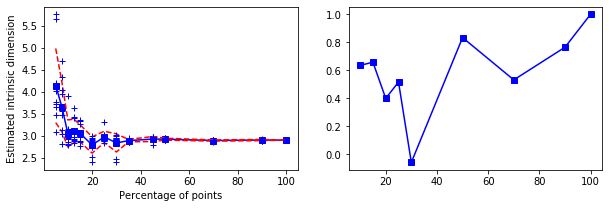

ess_dim_estimates


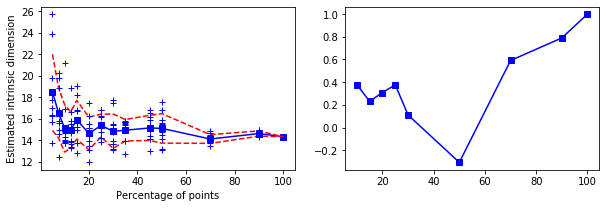

danco_dim_estimates


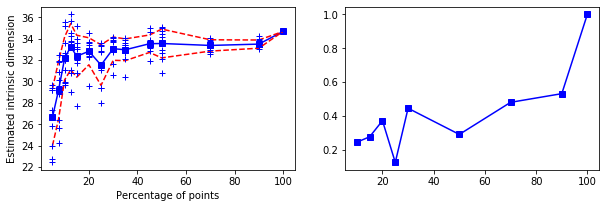

twonn_dim_estimates


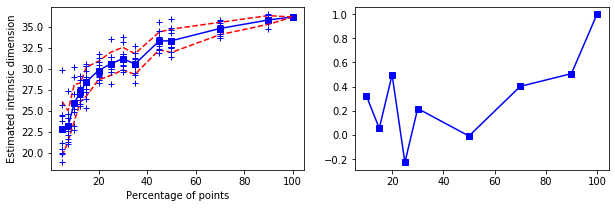

anova_dim_estimates


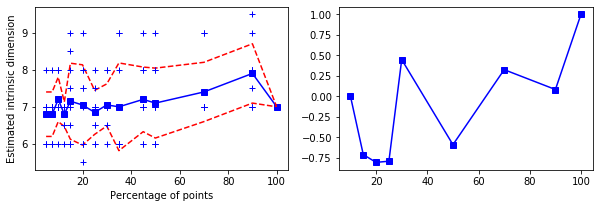

mle_dim_estimates


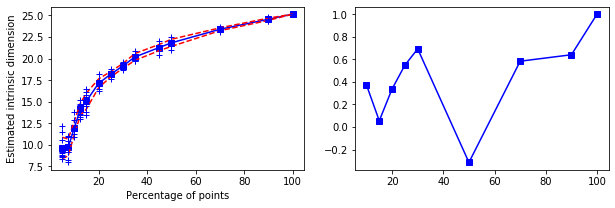

mind_dim_estimates


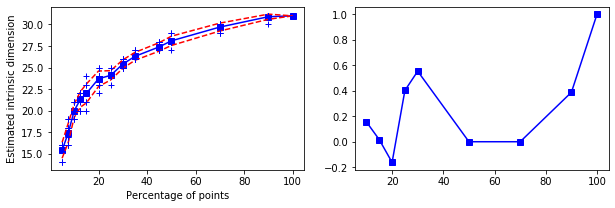

In [12]:
# plot convergence curve
alls=pd.read_csv('../results/'+dataset_name+'_all_sample_sizes.txt', sep='\t',header=None)
all_sample_sizes = alls.to_numpy()[:,0]
sizes=pd.read_csv('../results/'+dataset_name+'_sample_sizes.txt', sep='\t',header=None)
sample_sizes =sizes.to_numpy()[:,0]

estimators = ['fisherS_dim_estimates','ess_dim_estimates','danco_dim_estimates',
              'twonn_dim_estimates','anova_dim_estimates','mle_dim_estimates','mind_dim_estimates']

for estimator in estimators:
    print(estimator)
    ds=pd.read_csv('../results/'+dataset_name+'_'+estimator+'.txt', sep='\t',header=None)
    dim_estimates=ds.to_numpy()

    mn = np.mean(dim_estimates[:,:],1)
    std = np.std(dim_estimates[:,:],1)

    plt.figure(figsize=(10,3))
    plt.subplot(121)
    plt.plot(all_sample_sizes,mn,'bs-')
    plt.plot(all_sample_sizes,mn-std,'r--')
    plt.plot(all_sample_sizes,mn+std,'r--')
    plt.plot(all_sample_sizes,dim_estimates,'b+')
    plt.xlabel('Percentage of points')
    plt.ylabel('Estimated intrinsic dimension')

    ratios = []
    for sz in sample_sizes:
        sz_half = sz/2
        k = [i for i,asz in enumerate(all_sample_sizes) if np.abs(sz-asz)<0.001 ][0]
        k_half = [i for i,asz in enumerate(all_sample_sizes) if np.abs(sz_half-asz)<0.001 ][0]
        #print(k,all_sample_sizes[k],k_half,all_sample_sizes[k_half])
        ratios.append(1-std[k]/std[k_half])
        
    #avoid case of 0 std (nan ratio)
    ratios=np.array(ratios)
    ratios[np.isnan(ratios)]=1

    plt.subplot(122)
    plt.plot(sample_sizes,ratios,'bs-')
    plt.show()

### Study kNN ID

In [ ]:
num_neighbors = [100]
n_jobs = 4

#Run ID estimators pointwise in KNN neighborhoods of different sizes
for n_neighbors in num_neighbors:
    for dataset_name,data in [('nestorowa',pca_nestorowa)]:
    
        n_samples = data.shape[0]
        print(dataset_name)
        print('Running kNN ID for all estimators...\nNumber of samples = {}\nDimension = {}'.format(n_samples,data.shape[1]))
        print('----------------------------\n')
        print('kNN = ',n_neighbors)

        start_all=time.time()

        ests_pw_dict = DE.estimateAllMethodsLocally(data, k = n_neighbors, n_jobs = n_jobs)

        print('elapsed :',round(time.time()-start_all,2))

        with open('../results/ests_pw_dict_'+dataset_name+'_kNN'+str(n_neighbors)+'.pkl','wb') as f:
            pickle.dump(ests_pw_dict,f)

nestorowa
Running kNN ID for all estimators...
Number of samples = 1645
Dimension = 167
----------------------------

kNN =  100


From cffi callback <function _processevents at 0x7f3ac49275f0>:
Traceback (most recent call last):
  File "/home/utilisateur/.local/lib/python3.7/site-packages/rpy2/rinterface_lib/callbacks.py", line 262, in _processevents
    @ffi_proxy.callback(ffi_proxy._processevents_def,
KeyboardInterrupt
From cffi callback <function _processevents at 0x7f3ac49275f0>:
Traceback (most recent call last):
  File "/home/utilisateur/.local/lib/python3.7/site-packages/rpy2/rinterface_lib/callbacks.py", line 262, in _processevents
    @ffi_proxy.callback(ffi_proxy._processevents_def,
KeyboardInterrupt
From cffi callback <function _processevents at 0x7f3ac49275f0>:
Traceback (most recent call last):
  File "/home/utilisateur/.local/lib/python3.7/site-packages/rpy2/rinterface_lib/callbacks.py", line 262, in _processevents
    @ffi_proxy.callback(ffi_proxy._processevents_def,
KeyboardInterrupt
From cffi callback <function _processevents at 0x7f3ac49275f0>:
Traceback (most recent call last):
  File "/home/ut

### Study global pointwise ID

In [8]:
list_global_id = []
list_inseparability_id = []
for dataset_name,data in list(real_data_subsampled.items())[:1]:

    print(dataset_name)
    start_all=time.time()

    [n_alpha,n_single,p_alpha,alphas,separable_fraction,Xp] = SeparabilityAnalysis(data,ProducePlots=0)
    n_pointwise, idx = point_inseparability_to_pointID_onealpha(n_alpha,n_single,p_alpha,alphas,idx='all_separable')

    list_global_id.append(n_single[0])
    list_inseparability_id.append(n_pointwise)

    print('elapsed :',round(time.time()-start_all,2))

### Study the behavior of the statistics used by the various estimators